#Week 3 Assignment
Deep Learning on Cancer Detection
THe following is a Kaggle Cometition Use Case to use Deep Learning including a Convolution Neural Network to Predict the presence of cancer in an image. It is a binary image classification problem.

The data is from the the Assignbed Kaggle Comepttion at https://www.kaggle.com/competitions/histopathologic-cancer-detection

The data includes a training set of images with labels,  a test set of images without labels and a sample submission csv file

In [ ]:
#  importing packages (additional packages were added as needed through the notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import cv2

In [ ]:
# uploading files from kaggle  requires the downloading of a kaggle json to the local
from google.colab import files
uploaded = files.upload()  # Select and upload the kaggle.json file


Saving kaggle.json to kaggle.json


In [ ]:
# since the files are huge  7 GB  I am placing the files in the temp colab content folder
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle competitions download -c histopathologic-cancer-detection -p /content


100% 6.31G/6.31G [01:01<00:00, 116MB/s]
100% 6.31G/6.31G [01:01<00:00, 111MB/s]


In [ ]:
# unziping the dataset
!unzip /content/histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

#Data Preprocessing  
This section takes the data in Kaggle which are folders with training and test images and training labels and extracts them  using the filename as the id and creates the dataframes that are very simple, the image file  the id and the label for training and just the id and image for the test data.  

There is a Nan check performed and no null values found.

In [ ]:
# loading the training labels into a dataframe
train_labels_df = pd.read_csv('/content/train_labels.csv')

In [ ]:
# the next cells get the indicidual images from the content folders for train and test and ctreat the dataframes

import os

# list image files
train_images = os.listdir('/content/train')
test_images = os.listdir('/content/test')


In [ ]:
# create training dataFrame
train_df = pd.DataFrame({'filepath': ['/content/train/' + fname for fname in train_images]})


In [ ]:
# adjusted regular expression pattern to match the file path structures
pattern = r'/([^/]+).tif$'

# extract image ids
train_df['image_id'] = train_df['filepath'].str.extract(pattern)[0]

# check for any NaN values in the 'image_id' column
nan_rows = train_df[train_df['image_id'].isna()]
print(f'Rows with NaN image_id values: {len(nan_rows)}')
if len(nan_rows) > 0:
    print(nan_rows)

# if no NaN values are found merge the dataframes
if len(nan_rows) == 0:
    # Merge the dataframes on the 'image_id' column
    train_df = train_df.merge(train_labels_df, left_on='image_id', right_on='id')
else:
    print("Cannot proceed with merging due to NaN values in image_id column.")

# create testing dataFrame
test_df = pd.DataFrame({'filepath': ['/content/test/' + fname for fname in test_images]})

Rows with NaN image_id values: 0


#Exploratpry Data Analysis  (EDA)
Even though the data is very simple , we can still examine the data and show a sample of the images as well as look at the balance of the labels.

## Visualizations and Data
In this section,  you can see the first few rows of the data.

You can see that the training data has an index, a file id,  the actual image tif file and a lable

You can then see a histogram of the labels that shows there is a little imbalance in the target variable but not enough to be concerned or warrant treament like over or undersampling.

Yuu can then scroll through a sample of the images. I have separated the sample into cancer free (0) and cancerous (1) images

In [ ]:
# display first few rows of the dataframe
print(train_df.head())

# check class distribution
print(train_df['label'].value_counts())

# check  missing values
print(train_df.isnull().sum())

                                            filepath  \
0  /content/train/2aaa63b0a658f7194ae8d834cf3c183...   
1  /content/train/c552a9dfd4647d66d3cc9281060c675...   
2  /content/train/c2101cbacc629f3571b91b48b002d29...   
3  /content/train/c34943808a14287dab5e65f9ec13bcb...   
4  /content/train/1f596cdeb70a26162b71f0a816a3c73...   

                                   image_id  \
0  2aaa63b0a658f7194ae8d834cf3c18306eda7fee   
1  c552a9dfd4647d66d3cc9281060c67563dd376b9   
2  c2101cbacc629f3571b91b48b002d2998c292246   
3  c34943808a14287dab5e65f9ec13bcb49973a725   
4  1f596cdeb70a26162b71f0a816a3c7300f395530   

                                         id  label  
0  2aaa63b0a658f7194ae8d834cf3c18306eda7fee      0  
1  c552a9dfd4647d66d3cc9281060c67563dd376b9      0  
2  c2101cbacc629f3571b91b48b002d2998c292246      1  
3  c34943808a14287dab5e65f9ec13bcb49973a725      0  
4  1f596cdeb70a26162b71f0a816a3c7300f395530      1  
0    130908
1     89117
Name: label, dtype: int64
filepath    

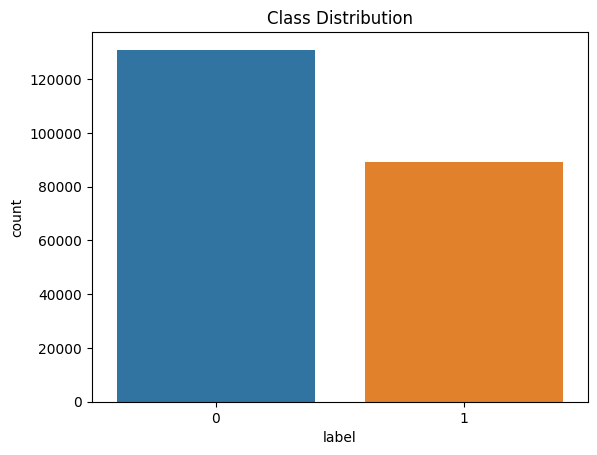

In [ ]:
sns.countplot(data=train_df, x='label')
plt.title('Class Distribution')
plt.show()


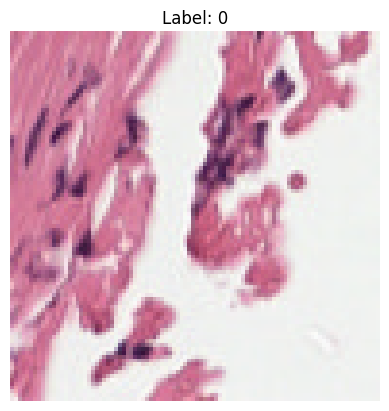

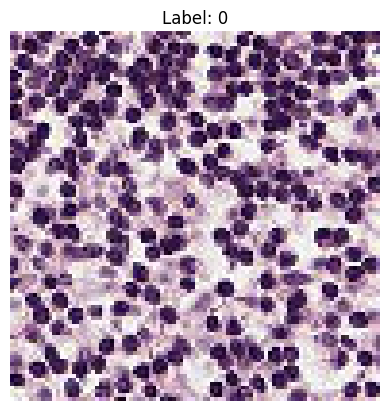

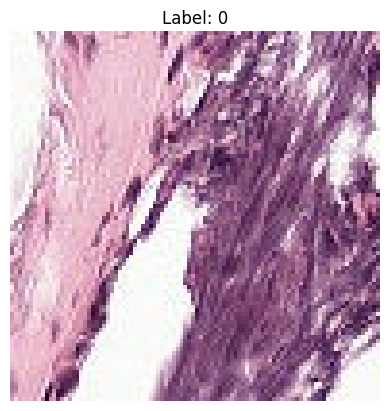

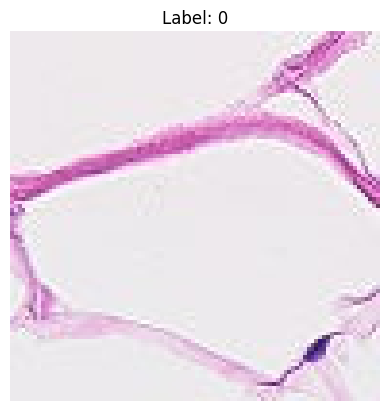

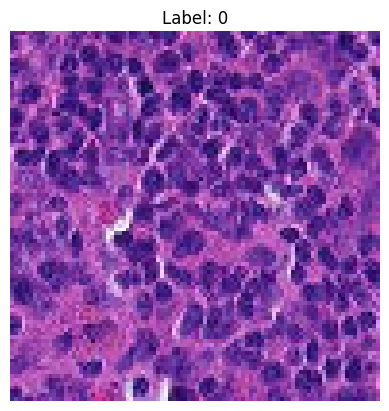

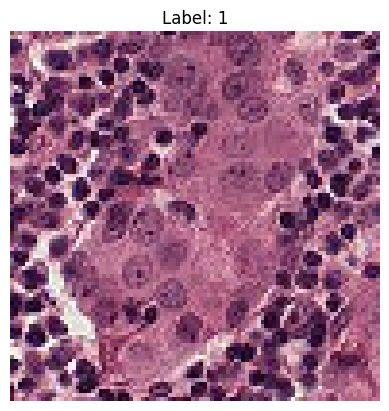

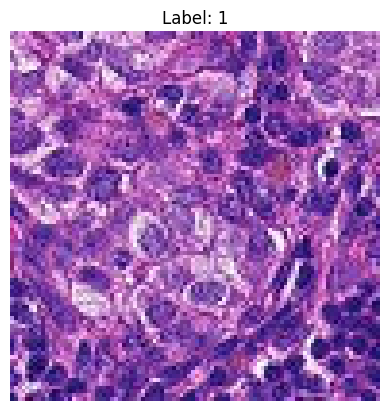

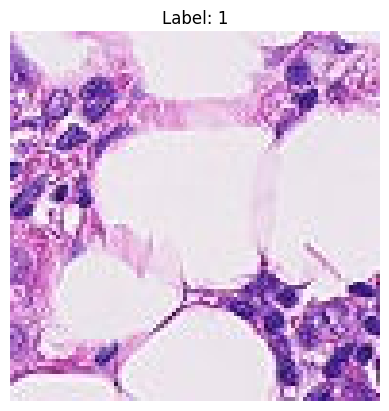

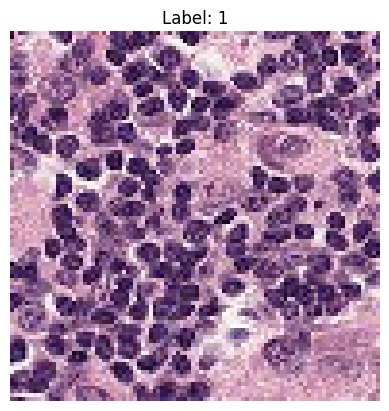

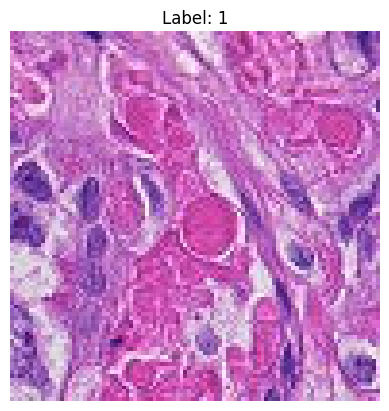

In [ ]:
def display_images(df, label, num_images=5):
    subset = df[df['label'] == label].sample(num_images)
    for index, row in subset.iterrows():
        img = cv2.imread(row['filepath'])
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

# display images for each class
for label in train_df['label'].unique():
    display_images(train_df, label)


In [ ]:
image_dims = [cv2.imread(img_path).shape for img_path in train_df['filepath']]
dims_df = pd.DataFrame(image_dims, columns=['Height', 'Width', 'Channels'])

# Displaying image dimensions statistics
print(dims_df.describe())


         Height     Width  Channels
count  220025.0  220025.0  220025.0
mean       96.0      96.0       3.0
std         0.0       0.0       0.0
min        96.0      96.0       3.0
25%        96.0      96.0       3.0
50%        96.0      96.0       3.0
75%        96.0      96.0       3.0
max        96.0      96.0       3.0


## Above we look at the data which is not interesting because all the images have the same dimensions but it does indicate that the images have 3 channels and thus are RGB images

In [ ]:
print(f"Duplicated images: {train_df.duplicated(subset='filepath').sum()}")
print(f"Duplicated labels: {train_df.duplicated(subset='id').sum()}")


Duplicated images: 0
Duplicated labels: 0


## There are no duplicate images as shown above

#Model Development and Training

In [ ]:
from sklearn.model_selection import train_test_split

# split the data into train and validation
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])


In [ ]:
# convert labels to strings
train_data['label'] = train_data['label'].astype(str)
val_data['label'] = val_data['label'].astype(str)


In [ ]:
print(train_df['label'].dtype)
print(val_data['label'].dtype)



int64
object


In [ ]:
from keras.preprocessing.image import ImageDataGenerator


# initialize the ImageDataGenerator to make the data more generalizable to prevent overfittine
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # set validation split
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='filepath',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

val_generator = train_datagen.flow_from_dataframe(
    val_data,
    x_col='filepath',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)


NameError: ignored

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

In [ ]:
#  creating batches
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break  # break after the first batch to prevent an endless loop

data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=val_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)


Epoch 1/15
100/100 - 19s - loss: 0.6641 - accuracy: 0.5941 - val_loss: 0.6795 - val_accuracy: 0.5425 - 19s/epoch - 195ms/step
Epoch 2/15
100/100 - 7s - loss: 0.5679 - accuracy: 0.7034 - val_loss: 0.4843 - val_accuracy: 0.7775 - 7s/epoch - 74ms/step
Epoch 3/15
100/100 - 7s - loss: 0.5021 - accuracy: 0.7594 - val_loss: 0.4883 - val_accuracy: 0.7750 - 7s/epoch - 73ms/step
Epoch 4/15
100/100 - 7s - loss: 0.5099 - accuracy: 0.7672 - val_loss: 0.5139 - val_accuracy: 0.7600 - 7s/epoch - 72ms/step
Epoch 5/15
100/100 - 7s - loss: 0.5177 - accuracy: 0.7553 - val_loss: 0.5020 - val_accuracy: 0.7750 - 7s/epoch - 72ms/step
Epoch 6/15
100/100 - 7s - loss: 0.4956 - accuracy: 0.7694 - val_loss: 0.4863 - val_accuracy: 0.7738 - 7s/epoch - 73ms/step
Epoch 7/15
100/100 - 7s - loss: 0.4746 - accuracy: 0.7759 - val_loss: 0.4879 - val_accuracy: 0.7837 - 7s/epoch - 74ms/step
Epoch 8/15
100/100 - 7s - loss: 0.4704 - accuracy: 0.7772 - val_loss: 0.4973 - val_accuracy: 0.7531 - 7s/epoch - 73ms/step
Epoch 9/15
10

In [ ]:
# save model
model.save('model.h5')

# save history
import pickle
with open('history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# download model and history to local
from google.colab import files
files.download('model.h5')
files.download('history.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

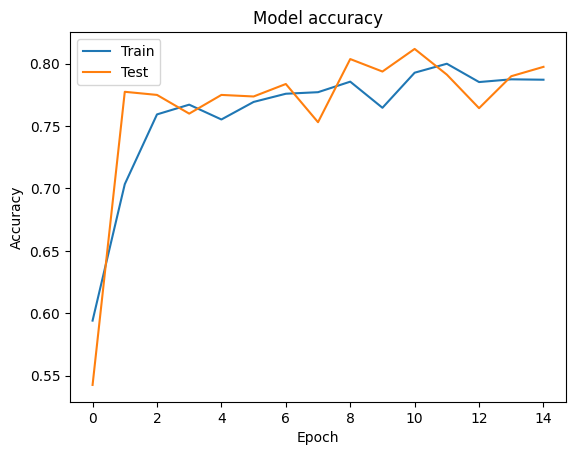

In [ ]:
import matplotlib.pyplot as plt

# plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



## The first model ran quickly, created reasonable accuracy and we did not appear to overfit.

The second model is going to have more data augmentation and add stopping and callbacks.  Other than that I did not change the architecture of the model.

In [ ]:
 # enhance with  data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# create Generators
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='filepath',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='filepath',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# architecture
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compile model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# add early stopping and callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

model_2.summary()


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856 

In [ ]:
# train the model
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
5501/5501 [==============================] - 319s 58ms/step - loss: 0.4487 - accuracy: 0.7951 - val_loss: 0.5413 - val_accuracy: 0.7499
Epoch 2/15
   2/5501 [..............................] - ETA: 4:43 - loss: 0.5185 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5501/5501 [==============================] - 314s 57ms/step - loss: 0.3898 - accuracy: 0.8267 - val_loss: 0.5270 - val_accuracy: 0.7585
Epoch 3/15
5501/5501 [==============================] - 314s 57ms/step - loss: 0.3749 - accuracy: 0.8349 - val_loss: 0.5722 - val_accuracy: 0.7481
Epoch 4/15
5501/5501 [==============================] - 315s 57ms/step - loss: 0.3604 - accuracy: 0.8422 - val_loss: 0.5507 - val_accuracy: 0.7594
Epoch 5/15
5501/5501 [==============================] - 314s 57ms/step - loss: 0.3486 - accuracy: 0.8480 - val_loss: 0.4991 - val_accuracy: 0.7655
Epoch 6/15
5501/5501 [==============================] - 314s 57ms/step - loss: 0.3396 - accuracy: 0.8527 - val_loss: 0.4070 - val_accuracy: 0.8165
Epoch 7/15
5501/5501 [==============================] - 316s 58ms/step - loss: 0.3296 - accuracy: 0.8582 - val_loss: 0.3980 - val_accuracy: 0.8212
Epoch 8/15
5501/5501 [==============================] - 320s 58ms/step - loss: 0.3215 - accuracy: 0.8629 - val_loss: 0.3571 - val

Model 2  achieved improved accuracy scores but we saw more noise in this model.  With the callbacks I was able to save the best epoch /model

In [ ]:
# save model
model_2.save('model_2.h5')

# save history
with open('history_2.pkl', 'wb') as file_pi:
    pickle.dump(history_2.history, file_pi)

# download model and history to local machine
from google.colab import files
files.download('model_2.h5')
files.download('history_2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

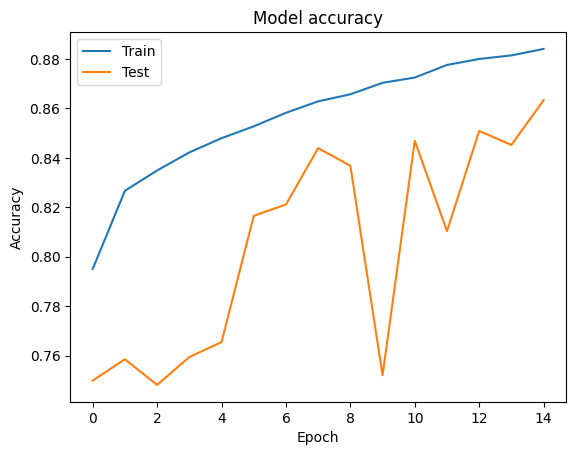

In [ ]:
# plot training & validation accuracy values
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

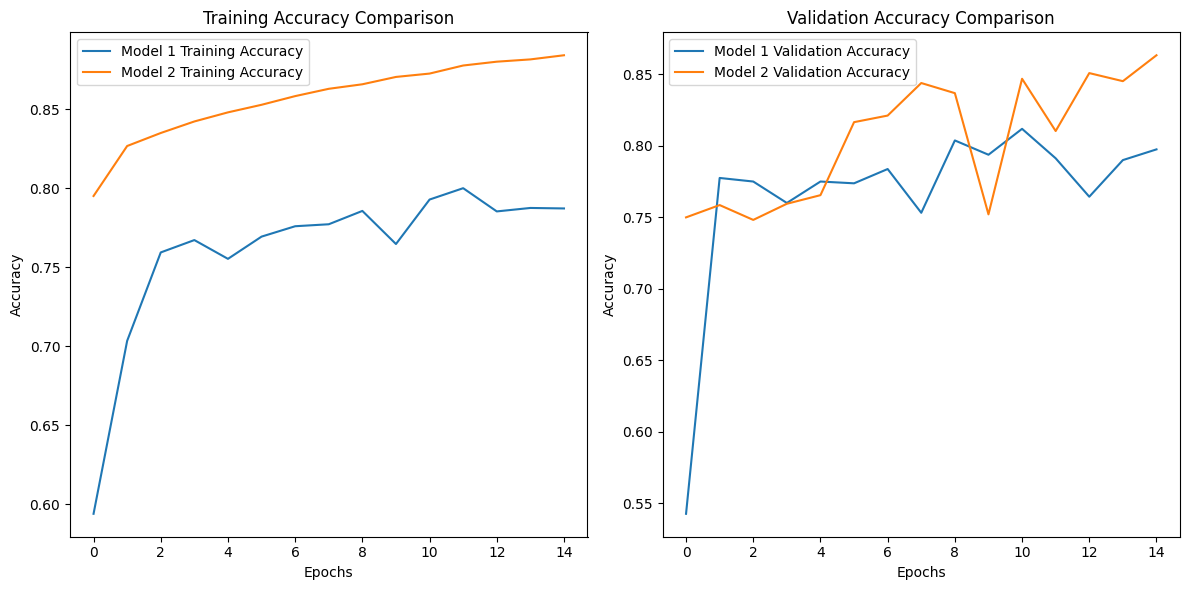

In [ ]:

def plot_history(history, history_2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting training accuracy
    ax[0].plot(history.history['accuracy'], label='Model 1 Training Accuracy')
    ax[0].plot(history_2.history['accuracy'], label='Model 2 Training Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training Accuracy Comparison')
    ax[0].legend()

    # Plotting validation accuracy
    ax[1].plot(history.history['val_accuracy'], label='Model 1 Validation Accuracy')
    ax[1].plot(history_2.history['val_accuracy'], label='Model 2 Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Validation Accuracy Comparison')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history, history_2)

THe side by side plots of model 1 and 2 show that mpodel 2 performed better with better training and validation accuracy. it is interesting that model two had more noise and that the best validation accuracy occured in epoch 10 not epoch 15

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

##  In my final model,  I left the image augmentation the same as model 2 but updated the architecture with batch normalization and with a dropout layer as well as an additional 5 epochs to see if i could further tune and improve the model.  These models were taking a long time to train so I made this my final model

In [ ]:
from keras.layers import GlobalAveragePooling2D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# improved Architecture
model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),  # Using GlobalAveragePooling instead of Flatten
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # Adding L2 regularization
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# adjusting learning rate for the Adam optimizer
optimizer = Adam(learning_rate=0.0005)

# Compiling the model
model_3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# enhancing Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_3_checkpoint.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)


In [ ]:
# training the model_3
history_3 = model_3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,  # Increased epochs
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Added ReduceLROnPlateau callback
)

Epoch 1/20
5501/5501 [==============================] - 322s 58ms/step - loss: 0.5395 - accuracy: 0.8285 - val_loss: 0.5114 - val_accuracy: 0.8152 - lr: 5.0000e-04
Epoch 2/20
5501/5501 [==============================] - 316s 57ms/step - loss: 0.3465 - accuracy: 0.8594 - val_loss: 0.5212 - val_accuracy: 0.8058 - lr: 5.0000e-04
Epoch 3/20
5501/5501 [==============================] - 316s 58ms/step - loss: 0.3244 - accuracy: 0.8716 - val_loss: 0.3814 - val_accuracy: 0.8392 - lr: 5.0000e-04
Epoch 4/20
5501/5501 [==============================] - 313s 57ms/step - loss: 0.3111 - accuracy: 0.8774 - val_loss: 0.6151 - val_accuracy: 0.7398 - lr: 5.0000e-04
Epoch 5/20
5501/5501 [==============================] - 314s 57ms/step - loss: 0.2990 - accuracy: 0.8833 - val_loss: 0.3499 - val_accuracy: 0.8638 - lr: 5.0000e-04
Epoch 6/20
5501/5501 [==============================] - 314s 57ms/step - loss: 0.2907 - accuracy: 0.8872 - val_loss: 0.3899 - val_accuracy: 0.8435 - lr: 5.0000e-04
Epoch 7/20
5501/

In [ ]:
# save model
model_3.save('model_3.h5')

# save history
with open('history_3.pkl', 'wb') as file_pi:
    pickle.dump(history_3.history, file_pi)

# download model and history to local machine
from google.colab import files
files.download('model_3.h5')
files.download('history_3.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp model.h5 /content/drive/My\ Drive/


Mounted at /content/drive


In [ ]:
!cp model_2.h5 /content/drive/My\ Drive/


In [ ]:
!cp model_3.h5 /content/drive/My\ Drive/


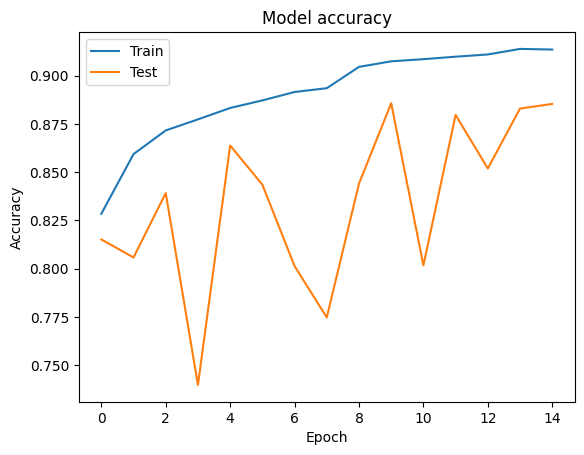

In [ ]:
# plot training & validation accuracy values
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

THe final model achieved the best accuracy to date although again we see a lot of noise during validation

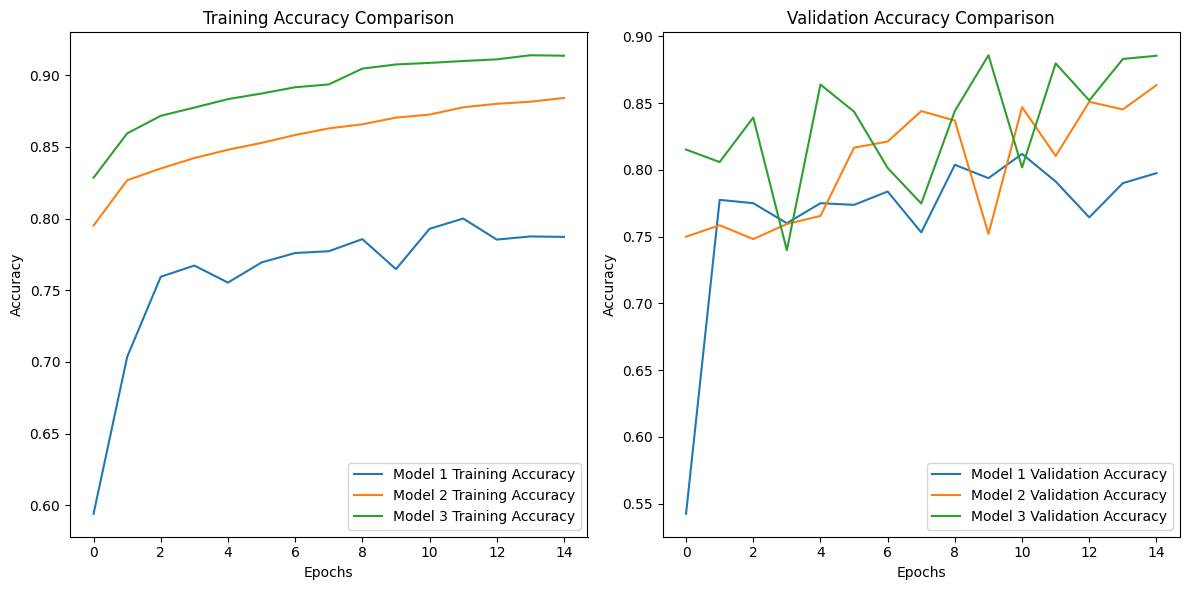

In [ ]:
#  plot the comparison
def plot_history(history, history_2, history_3):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # plotting training accuracy
    ax[0].plot(history.history['accuracy'], label='Model 1 Training Accuracy')
    ax[0].plot(history_2.history['accuracy'], label='Model 2 Training Accuracy')
    ax[0].plot(history_3.history['accuracy'], label='Model 3 Training Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training Accuracy Comparison')
    ax[0].legend()

    # plotting validation accuracy
    ax[1].plot(history.history['val_accuracy'], label='Model 1 Validation Accuracy')
    ax[1].plot(history_2.history['val_accuracy'], label='Model 2 Validation Accuracy')
    ax[1].plot(history_3.history['val_accuracy'], label='Model 3 Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Validation Accuracy Comparison')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history, history_2, history_3)

Here we get to see all of the models together and we see the superior results of the final model  We see that efforts to adjust the learning rate, add dropouts and baych normalization imrpoved the model.  

@ Predict the test file and save to a csv for Kaggle cometition grading

In [ ]:
from keras.preprocessing import image

In [ ]:
from keras.preprocessing import image
import os
import numpy as np
import pandas as pd

# determine the best model based on validation accuracy
val_acc_model_1 = max(history.history['val_accuracy'])
val_acc_model_2 = max(history_2.history['val_accuracy'])
val_acc_model_3 = max(history_3.history['val_accuracy'])

# determine the best model
if val_acc_model_1 >= val_acc_model_2 and val_acc_model_1 >= val_acc_model_3:
    best_model = model
elif val_acc_model_2 >= val_acc_model_1 and val_acc_model_2 >= val_acc_model_3:
    best_model = model_2
else:
    best_model = model_3

# Saving best model to a file
best_model.save('best_model.h5')
!cp best_model.h5 /content/drive/My\ Drive/

#  test files
test_dir = '/content/test'

#  test file paths
test_files = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]

#  empty list to store your predictions
predictions = []

# iterate over test files to make predictions
for test_file in test_files:
    img = image.load_img(test_file, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0  # Remember to rescale the images
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    prediction = best_model.predict(img_array_expanded_dims)
    predictions.append(1 if prediction[0][0] > 0.5 else 0)  # Assuming 0.5 threshold

# create a DataFrame for predictions
predictions_df = pd.DataFrame({
    'file_name': [os.path.basename(test_file) for test_file in test_files],
    'prediction': predictions
})

# save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step


In [ ]:
from google.colab import files

# save predictions to csv file locally
files.download('predictions.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Conclusion
I was able to extract the files from Kaggle, convert them to dataframes and examine them for completeness.  Once I did that I created three models.  The first was the simplest model.  Then i used data augmentation to make the images more generalizable.  And in the final model,  I made a more complex architecture.  Each set in fine tuning improved the model.  I learned that Deep Learning is much more compuationaly intenseve and took a long, long time.   I also leanred how to extract data from Kaggle and how to use the contnet files in Colab.   It was a great learning experience.